### NOTES

Initialization 

Weights distribution needs to be roughly unit gaussian

This is because of non-linear functions, which domain is (-1,1) (tanh) , (0,x)(ReLu), etc. Values higher or lower than STD of 1 are problematic because the gradien vanishes or causes dead neurons. E.g. 2 input values -30 and -40 have the same effect of outputing -1 in a tanh function, and given that the gradient of grad(tanh(-1)=0), there is no gradient broadcasted in the network.

So it is important to inialize weights properly. This is usually done by adding certain gains and normalizations that are in function of fan_in and
different magic numbers.

But for bigger neural networks, this becomes problematic because it is difficult to compute gains functions for weight initialization.

To address this problem, one can use Batch normalization (BN)

A BN layer normalizes the output of layers to make them unit gaussian (0 mean and 1 std/var)

It is called BATCH normalization because it computes the mean and std/var given a single training batch during training time.

It is common to sprinkle Batch normalization into linear or convolutional layers

BN makes deep neural networks training more stable even with many layers. Also one does not have to worry about weight initialization anymore

The stability of BN comes at a cost. BN couples forward propagation with the batch itself, because now the STD and MEAN of the batch are part of the forward pass. So there will be some noise in terms of the distribution of the weights depending on the batch

But this noise helps to regularize the net and prevents the weights of the net to overfit

BN also makes the input of the forward pass to depend on the STD and MEAN of the batch. So at inference time, we calculate the STD and MEAN of all the dataset (train, test or val) and use these fix values for inference forward pass. This can be done also during training time to avoid a second stage computation.

If using BN, it is better to not to have biases to the layer attached to BN

Group Normalization and Layer normalization are better options as BN suffer from a lot of bugs.

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

DEBUG = True
debug = lambda *args: print(*args) if DEBUG else None

In [2]:
words = open('names.txt','r').read().splitlines()
debug(words[:8])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# Build the encoders

chars = sorted(set(list("".join(w for w in words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
vocab_size = len(stoi)

In [4]:
import random

# Build the dataset
context_size = 3
def build_dataset(words):
    X, Y = [],[]
    context = [0] * context_size
    for w in words:
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

debug(f"{Xtr.shape=},{Ytr.shape=}")
debug(f"{Xdev.shape=},{Ydev.shape=}")
debug(f"{Xte.shape=},{Yte.shape=}")
debug(f"{Xtr[0]=} -> {Ytr[0]=}")

Xtr.shape=torch.Size([182625, 3]),Ytr.shape=torch.Size([182625])
Xdev.shape=torch.Size([22655, 3]),Ydev.shape=torch.Size([22655])
Xte.shape=torch.Size([22866, 3]),Yte.shape=torch.Size([22866])
Xtr[0]=tensor([0, 0, 0]) -> Ytr[0]=tensor(25)


In [5]:
# MLP

embeddings_size = 10
hidden_size = 200

g = torch.Generator().manual_seed(2147483647)

init_gain = (5/3)/((embeddings_size * context_size)**0.5)  #gain/sqrt(fan_in) manual tanh initialization https://pytorch.org/docs/stable/nn.init.html

C = torch.randn((vocab_size, embeddings_size), generator=g)
W1 = torch.randn((embeddings_size * context_size, hidden_size), generator=g) * init_gain
B1 = torch.randn((1, hidden_size),generator=g)
W2 = torch.randn((hidden_size, vocab_size),generator=g)
B2 = torch.randn((1, vocab_size),generator=g)

# Batch Normalization parameters

bngains = torch.ones((1,hidden_size))
bnbias = torch.zeros((1,hidden_size))

bnmean_running = torch.zeros((1,hidden_size))
bnstd_running = torch.ones((1,hidden_size))

params = [C,W1, B1, W2, B2, bngains, bnbias]

print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

12297


In [6]:
# Optimization
DEBUG = False

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Build minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    debug(f"{ix.shape=}")

    Xb, Yb = Xtr[ix], Ytr[ix]
    debug(f"{Xb.shape=}")
    debug(f"{Yb.shape=}")
    
    # Forward pass
    emb = C[Xb]
    debug(f'{emb.shape=}')
    
    embcat = emb.view(batch_size, -1)
    debug(f'{embcat.shape=}')
    
    hpreact = embcat @ W1 + B1
    debug(f'{hpreact.shape=}')

    # Batch normalization
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    debug(f'{bnmeani.shape=}')
    debug(f'{bnstdi.shape=}')

    hpreact = (bngains * (hpreact - bnmeani) / bnstdi + bnbias)
    debug(f'{hpreact.shape=}')

    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * bnmeani
        bnstd_running = 0.99 * bnstd_running + 0.01 * bnstdi

    h = torch.tanh(hpreact)

    logits = (h @ W2 + B2)
    loss = F.cross_entropy(logits, Yb)
    debug(f'{logits.shape=}')
    debug(f'{loss.shape=}')

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data = p.data - lr * p.grad
        #p.data += -lr * p.grad
    

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 19.7371
  10000/ 200000: 2.5510
  20000/ 200000: 2.3473
  30000/ 200000: 2.7050
  40000/ 200000: 2.0024
  50000/ 200000: 2.3446
  60000/ 200000: 2.2824
  70000/ 200000: 2.0859
  80000/ 200000: 2.2843
  90000/ 200000: 2.1809
 100000/ 200000: 2.1902
 110000/ 200000: 2.5697
 120000/ 200000: 2.0927
 130000/ 200000: 2.5562
 140000/ 200000: 2.5420
 150000/ 200000: 2.3227
 160000/ 200000: 2.1251
 170000/ 200000: 1.8279
 180000/ 200000: 2.1778
 190000/ 200000: 1.8843


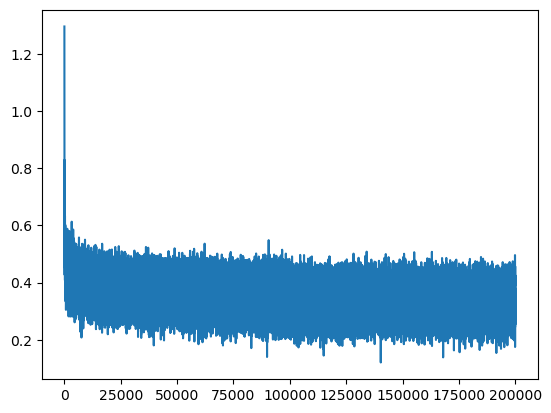

In [7]:
plt.plot(lossi)

In [8]:
# What mean and std we should use after training? The mean and the std and computed per batch during training
# Recalibrate the the mean and std with the whole training dataset

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngains * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + B2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4248063564300537
val 2.4471030235290527


In [56]:
# PYTORCHIFYING

from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x) -> torch.Tensor: # TODO: DEBUG IF THIS WORKS!
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else {self.bias})
    
class BarchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters trained with backprop
        # Because normalization constrains the distribution that could affect performance, we add 2 parameters to rescale and shift
        # it and we let the network learn by how much
        self.gamma = torch.ones(dim) # BN gains
        self.beta = torch.zeros(dim) # BN beta

        # Buffers updated with momentum updates
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self,x) -> torch.Tensor:
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0 , keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_variance
        
        #Normalize the parameter distribution to a normal gaussina with zero mean and unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_variance = self.running_variance * (1 - self.momentum) + xvar * self.momentum

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(context_size * n_emb, n_hidden, False),  BarchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, False),              BarchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, False),              BarchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, False),              BarchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, False),              BarchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, vocab_size, False),            BarchNorm1d(vocab_size)
]

with torch.no_grad():
    # Last layer less confident
    layers[-1].gamma *= 0.1

    # All other layers, apply gain
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 1 # Here we would have 5/3 if we did not had BN and we had to manually initialize the layers

parameters = [C] + [p for layer in layers for p in layer.parameters()]

debug(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [58]:
# Feed forward and backprop

max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # Build batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward
    emb = C[Xb]
    x = emb.view(batch_size,-1)

    for l in layers:
        x = l(x)

    loss = F.cross_entropy(x, Yb)

    # Backprop
    
    # AFTER_DEBUG This is only for debugging. We want to retain the gradients so we can plot them and inspect them
    for l in layers:
        l.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the gradients
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # For debuging, we want to log the rate between the update of the gradient (i.e. lr * grad) vs the data itself
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2910


In [34]:
debug(f'{Xtr.shape=}')

Xtr.shape=torch.Size([182625, 3])


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.91%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.16%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

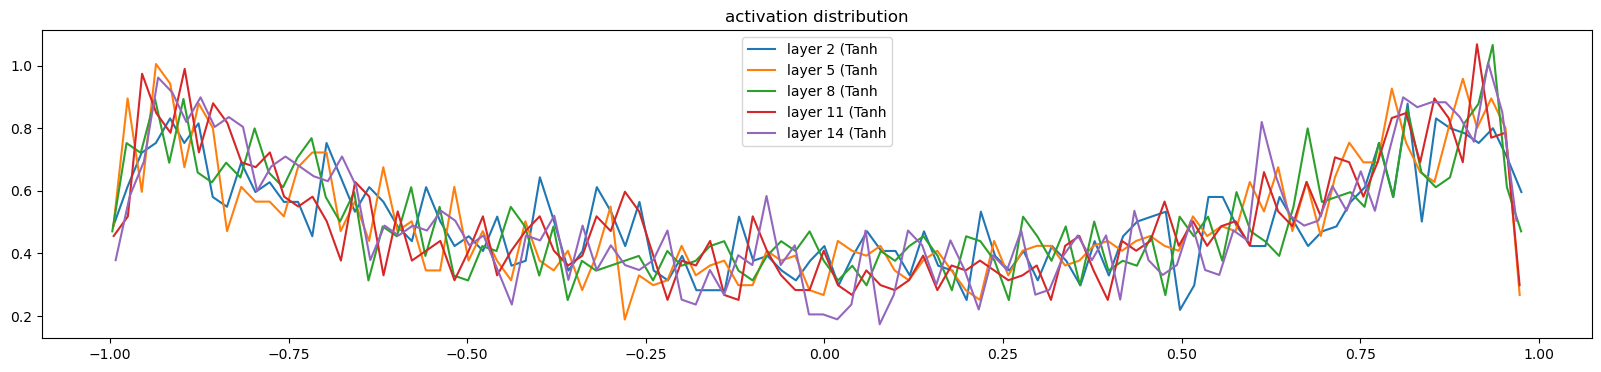

In [62]:
# visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.910825e-03
layer 5 (      Tanh): mean -0.000000, std 2.484604e-03
layer 8 (      Tanh): mean -0.000000, std 2.267806e-03
layer 11 (      Tanh): mean -0.000000, std 2.122782e-03
layer 14 (      Tanh): mean -0.000000, std 2.066393e-03


Text(0.5, 1.0, 'gradient distribution')

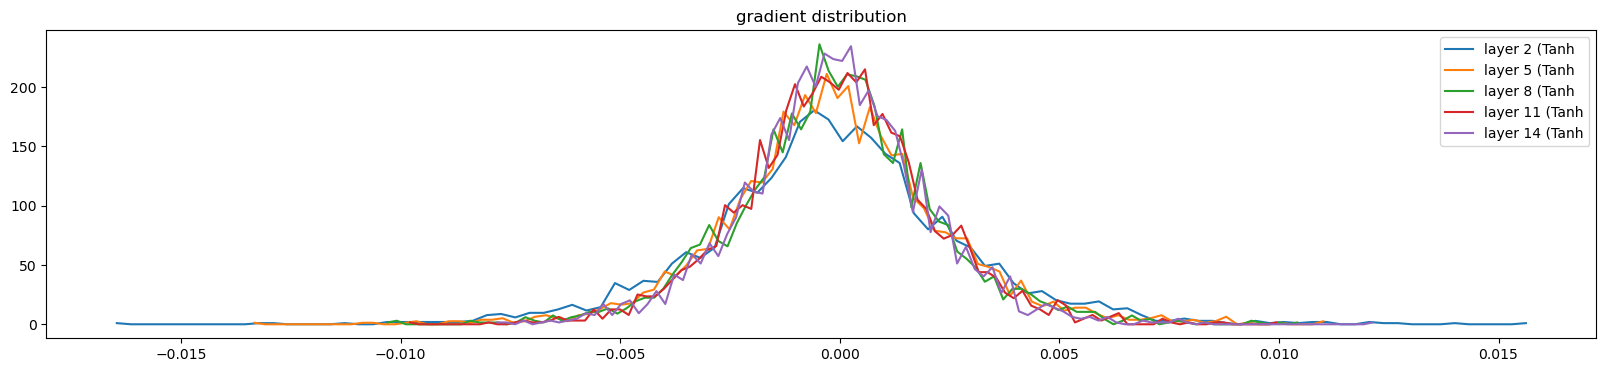

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.231125e-03 | grad:data ratio 9.221819e-03
weight  (30, 100) | mean +0.000252 | std 1.099662e-02 | grad:data ratio 5.808119e-02
weight (100, 100) | mean +0.000059 | std 8.002214e-03 | grad:data ratio 7.819089e-02
weight (100, 100) | mean +0.000088 | std 6.928727e-03 | grad:data ratio 6.750156e-02
weight (100, 100) | mean -0.000119 | std 6.412457e-03 | grad:data ratio 6.292697e-02
weight (100, 100) | mean -0.000060 | std 6.200111e-03 | grad:data ratio 6.089874e-02
weight  (100, 27) | mean +0.000082 | std 1.225497e-02 | grad:data ratio 1.178152e-01


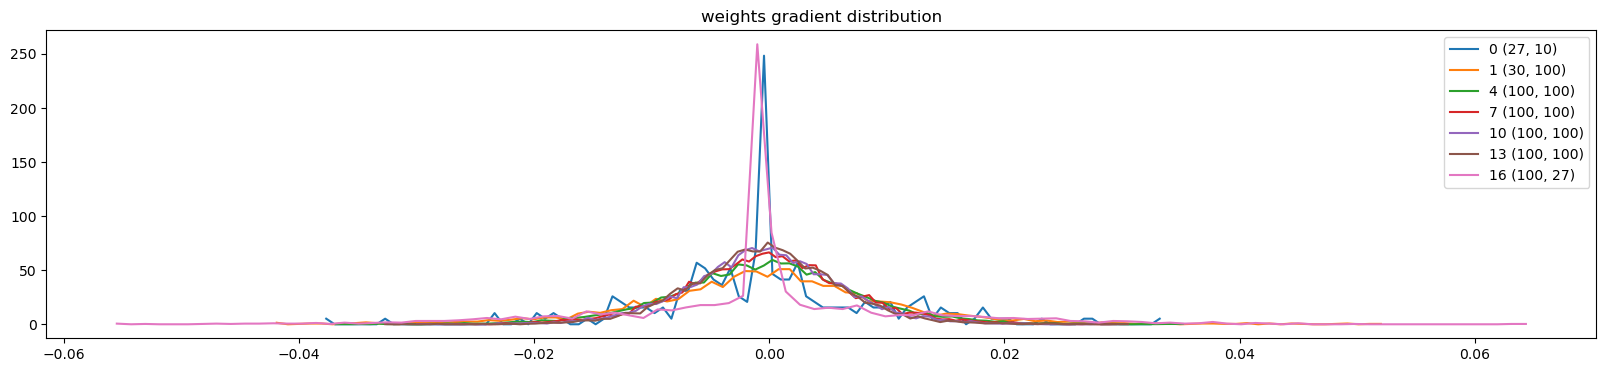

In [68]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

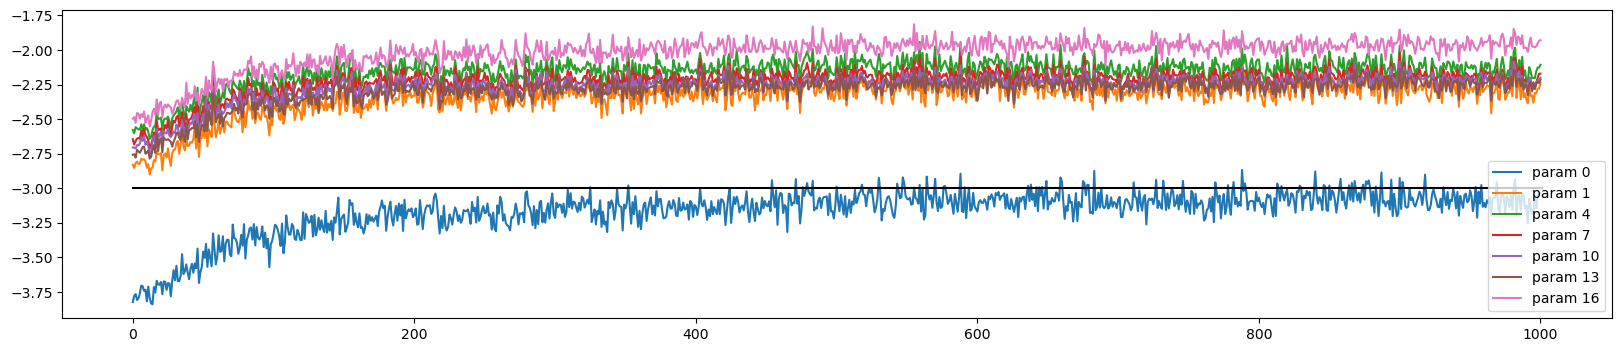

In [69]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Text(0.5, 1.0, 'activation distribution')

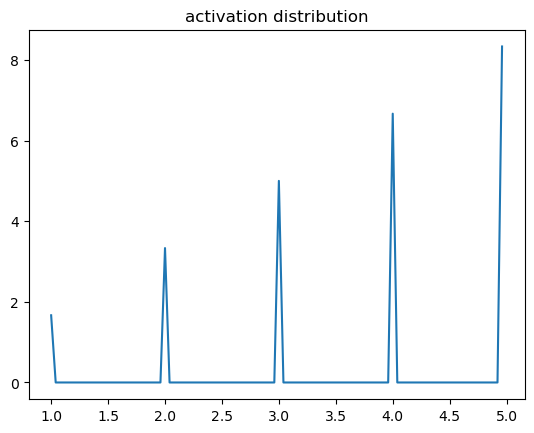

In [66]:
# Understanding histograms in pytorch
x = torch.tensor([1,2,3,4,5,5,5,5,5,4,4,4,3,3,2]).float()
hy, hx = torch.histogram(x, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.title('activation distribution')

In [70]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.417062520980835
val 2.4185733795166016


In [72]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mrianamyan.
see.
madhn.
alarenyrstendrlen.
ade.
edieliileli.
relle.
eineananar.
elyn.
mrona.
miyshdbergshiries.
kin.
rwellelxnthacanue.
mavdar.
yriue.
ehs.
ray.
mistonan.
hyl.
salyansui.
